# 🧠 LoRA vs Full Fine-tuning Analysis

## 📚 Import necessary libraries

In [1]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import stats

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuration
BASE_DIR = 'outputs/mobilevit_lora_vs_full_20251009_013414'
print(f"Analyzing: {BASE_DIR}\n")

Analyzing: outputs/mobilevit_lora_vs_full_20251009_013414



## 📊 Data Loading

In [2]:
def extract_experiment_info(subdir_name):
    """Extract dataset, use_lora, and lr from directory name."""
    parts = subdir_name.rsplit('_', 2)
    if len(parts) != 3:
        return 'unknown', False, 1e-4
    
    dataset = parts[0]
    exp_type = parts[1]
    use_lora = exp_type == 'lora'
    
    lr_part = parts[2]
    lr = float(lr_part.replace('lr', '')) if lr_part.startswith('lr') else 1e-4
    
    return dataset, use_lora, lr

def load_results_from_directory(subdir_path, subdir_name):
    """Load all results from a single experiment directory."""
    config_path = os.path.join(subdir_path, 'config.json')
    history_path = os.path.join(subdir_path, 'training_history.csv')
    test_path = os.path.join(subdir_path, 'test_results.csv')
    
    if not os.path.exists(config_path) or not os.path.exists(history_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    history_df = pd.read_csv(history_path)
    test_df = pd.read_csv(test_path) if os.path.exists(test_path) else None
    
    dataset, use_lora, lr = extract_experiment_info(subdir_name)
    
    train_final = history_df[history_df['phase'] == 'train'].iloc[-1]
    
    results = {
        'experiment': subdir_name,
        'dataset': dataset,
        'use_lora': use_lora,
        'lr': config['learning_rate'],
        'epochs': config['epochs'],
        'total_params': config['model_parameters']['total'],
        'trainable_params': config['model_parameters']['trainable'],
        'trainable_pct': config['model_parameters']['trainable_percentage'],
        'train_loss': train_final['loss'],
        'train_acc': train_final['avg_accuracy'],
        'train_f1': train_final['avg_f1'],
        'avg_time_per_epoch': history_df[history_df['phase'] == 'train']['time_seconds'].mean(),
    }
    
    if 'lora_config' in config:
        results['lora_r'] = config['lora_config']['r']
        results['lora_alpha'] = config['lora_config']['alpha']
    
    if test_df is not None and len(test_df) > 0:
        test_row = test_df.iloc[0]
        results.update({
            'test_loss': test_row['loss'],
            'test_acc': test_row['avg_accuracy'],
            'test_f1': test_row['avg_f1'],
            'test_precision': test_row['avg_precision'],
            'test_recall': test_row['avg_recall'],
            'test_auc': test_row['avg_auc']
        })
    
    return results

def load_all_experiments(base_dir):
    """Load all experiments."""
    all_results = []
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if not os.path.isdir(subdir_path) or subdir == 'base_model':
            continue
        results = load_results_from_directory(subdir_path, subdir)
        if results:
            all_results.append(results)
    
    df = pd.DataFrame(all_results)
    
    numeric_cols = ['lr', 'epochs', 'total_params', 'trainable_params', 'trainable_pct',
                    'train_loss', 'train_acc', 'train_f1', 'avg_time_per_epoch',
                    'test_loss', 'test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

# Load data
df = load_all_experiments(BASE_DIR)
print(f"Loaded {len(df)} experiments")

Loaded 18 experiments


In [3]:
df.head()

,experiment,dataset,use_lora,lr,epochs,total_params,trainable_params,trainable_pct,train_loss,train_acc,train_f1,avg_time_per_epoch,test_loss,test_acc,test_f1,test_precision,test_recall,test_auc,lora_r,lora_alpha
0,brics2025_full_lr1e-3,brics2025,False,0.0010,10,4940196,4940196,100.00,0.055419,0.991667,0.983364,3.893424,0.137089,0.976562,0.951386,0.950247,0.957291,0.998922,NaN,NaN
1,brics2025_full_lr5e-4,brics2025,False,0.0005,10,4940196,4940196,100.00,0.024190,0.996250,0.992447,4.060492,0.104544,0.986719,0.974661,0.976384,0.973708,0.998774,NaN,NaN
2,brics2025_full_lr1e-4,brics2025,False,0.0001,10,4940196,4940196,100.00,0.020886,0.996667,0.993481,3.860718,0.141470,0.983594,0.968169,0.970417,0.967687,0.998514,NaN,NaN
3,brics2025_lora_lr1e-3,brics2025,True,0.0010,10,4971176,30980,0.62,0.037057,0.993021,0.986394,2.324108,0.149536,0.975781,0.954171,0.956609,0.954087,0.997938,4.0,32.0
4,brics2025_lora_lr5e-4,brics2025,True,0.0005,10,4971176,30980,0.62,0.065593,0.988125,0.976868,2.335964,0.114913,0.976562,0.954714,0.955494,0.954975,0.998071,4.0,32.0


## 📈 Summary Statistics

In [4]:
print("Summary Statistics: LoRA vs Full Fine-tuning")
print("="*80)

full_df = df[df['use_lora'] == False]
lora_df = df[df['use_lora'] == True]

metrics = ['test_acc', 'test_f1', 'test_auc', 'trainable_pct', 'avg_time_per_epoch']
summary = pd.DataFrame({
    'Full (mean)': full_df[metrics].mean(),
    'Full (std)': full_df[metrics].std(),
    'LoRA (mean)': lora_df[metrics].mean(),
    'LoRA (std)': lora_df[metrics].std(),
    'Difference': lora_df[metrics].mean() - full_df[metrics].mean()
})
print(summary)

Summary Statistics: LoRA vs Full Fine-tuning
                    Full (mean)  Full (std)  LoRA (mean)  LoRA (std)  \
test_acc               0.986815    0.008056     0.979234    0.017525   
test_f1                0.973759    0.018090     0.958807    0.035638   
test_auc               0.998854    0.000778     0.995871    0.006152   
trainable_pct        100.000000    0.000000     0.616667    0.005000   
avg_time_per_epoch     5.903111    2.432920     3.550372    1.501298   

                    Difference  
test_acc             -0.007581  
test_f1              -0.014952  
test_auc             -0.002983  
trainable_pct       -99.383333  
avg_time_per_epoch   -2.352739  


## 📊 Core Visualizations

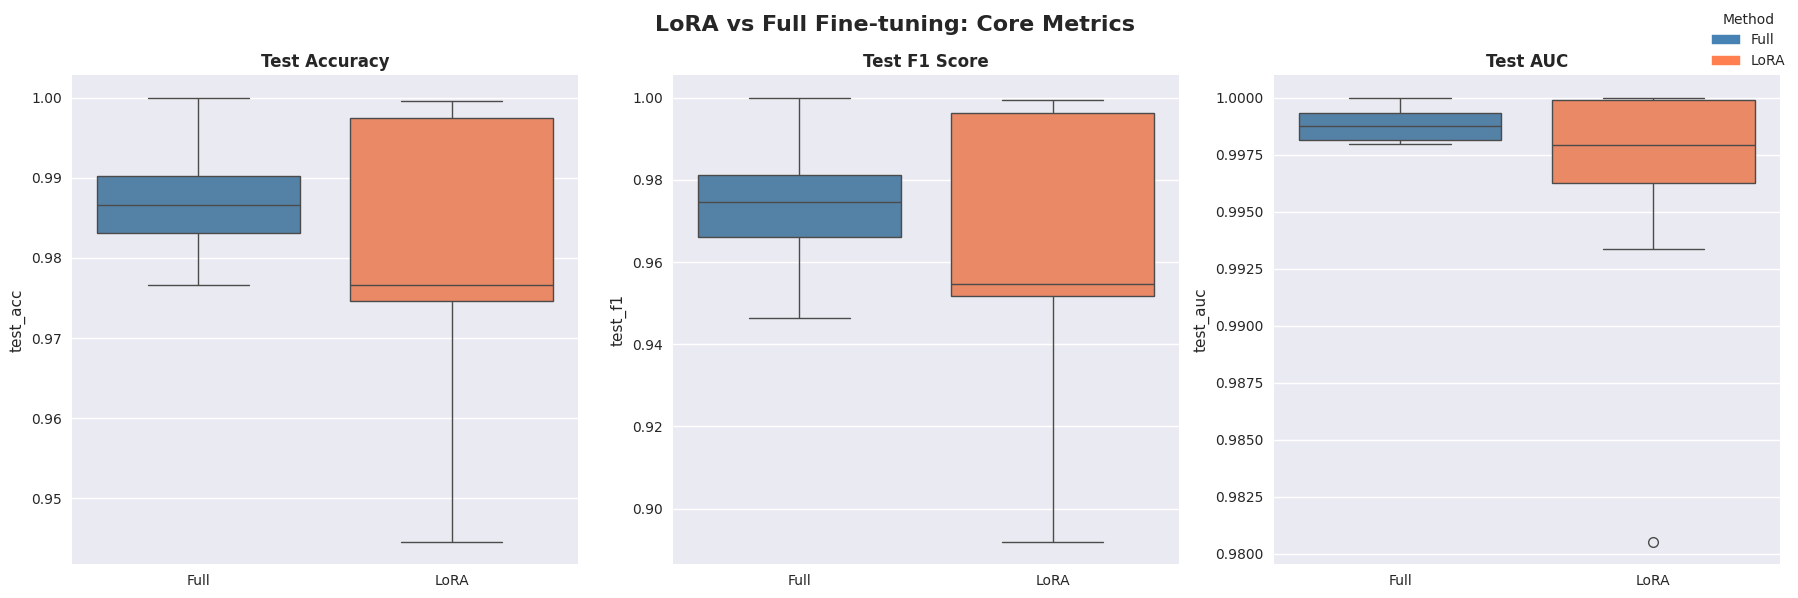

In [5]:
# Main Comparison: 3 Key Metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('LoRA vs Full Fine-tuning: Core Metrics', fontsize=16, fontweight='bold')

metrics_plot = [
    ('test_acc', 'Test Accuracy'),
    ('test_f1', 'Test F1 Score'),
    ('test_auc', 'Test AUC')
]

for idx, (metric, title) in enumerate(metrics_plot):
    ax = axes[idx]
    sns.boxplot(data=df, x='use_lora', y=metric, ax=ax, palette=['steelblue', 'coral'])
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')
    ax.set_xticklabels(['Full', 'LoRA'])

# Add legend to the figure
handles = [plt.Rectangle((0,0),1,1, color='steelblue'), plt.Rectangle((0,0),1,1, color='coral')]
fig.legend(handles, ['Full', 'LoRA'], title='Method', loc='upper right')

plt.tight_layout()
plt.show()

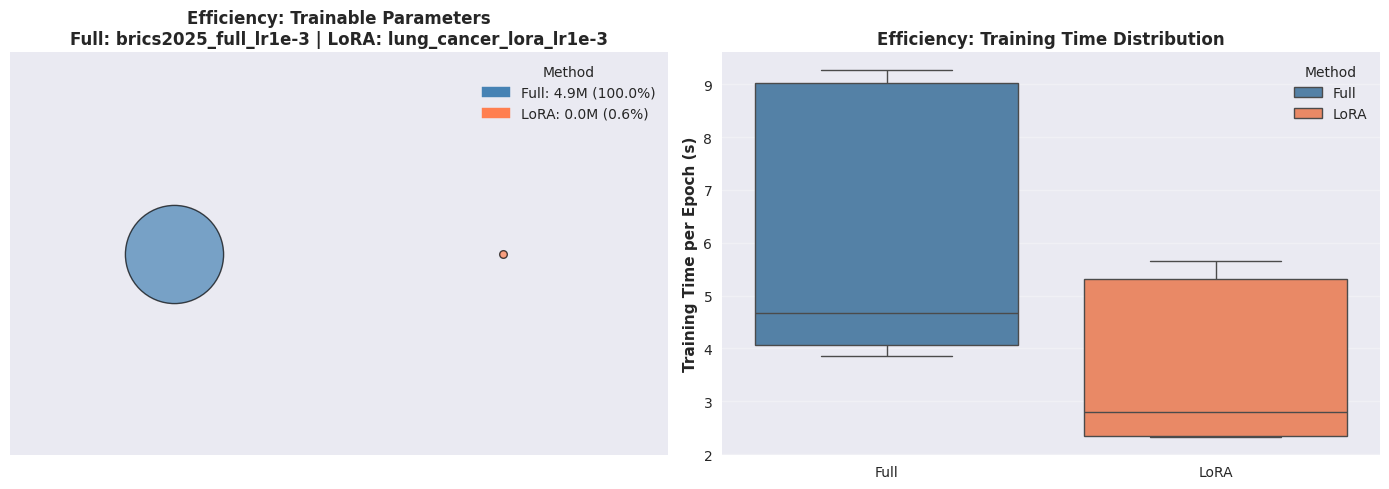

In [6]:
# Efficiency Trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Select specific runs: Full with highest trainable_pct, LoRA with lowest trainable_pct
full_example = full_df.loc[full_df['trainable_pct'].idxmax()]
lora_example = lora_df.loc[lora_df['trainable_pct'].idxmin()]

full_params = full_example['trainable_params'] / 1e6
full_pct = full_example['trainable_pct']
lora_params = lora_example['trainable_params'] / 1e6
lora_pct = lora_example['trainable_pct']

sizes = [full_pct * 50, lora_pct * 50] 
axes[0].scatter([0], [0], s=sizes[0], alpha=0.7, color='steelblue', edgecolors='black', linewidths=1)
axes[0].scatter([1], [0], s=sizes[1], alpha=0.7, color='coral', edgecolors='black', linewidths=1)
axes[0].set_xlim(-0.5, 1.5)
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title(f'Efficiency: Trainable Parameters\nFull: {full_example["experiment"]} | LoRA: {lora_example["experiment"]}', fontweight='bold')

handles = [mpatches.Circle((0,0), radius=5, color='steelblue'), mpatches.Circle((0,0), radius=5, color='coral')]
labels = [f'Full: {full_params:.1f}M ({full_pct:.1f}%)', f'LoRA: {lora_params:.1f}M ({lora_pct:.1f}%)']
axes[0].legend(handles, labels, title='Method')
axes[0].grid(False)

# Time vs Accuracy: Boxplot
sns.boxplot(data=df, x='use_lora', y='avg_time_per_epoch', ax=axes[1], palette=['steelblue', 'coral'])
axes[1].set_xlabel('')
axes[1].set_xticklabels(['Full', 'LoRA'])
axes[1].set_ylabel('Training Time per Epoch (s)', fontweight='bold')
axes[1].set_title('Efficiency: Training Time Distribution', fontweight='bold')
axes[1].legend(['Full', 'LoRA'], title='Method')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

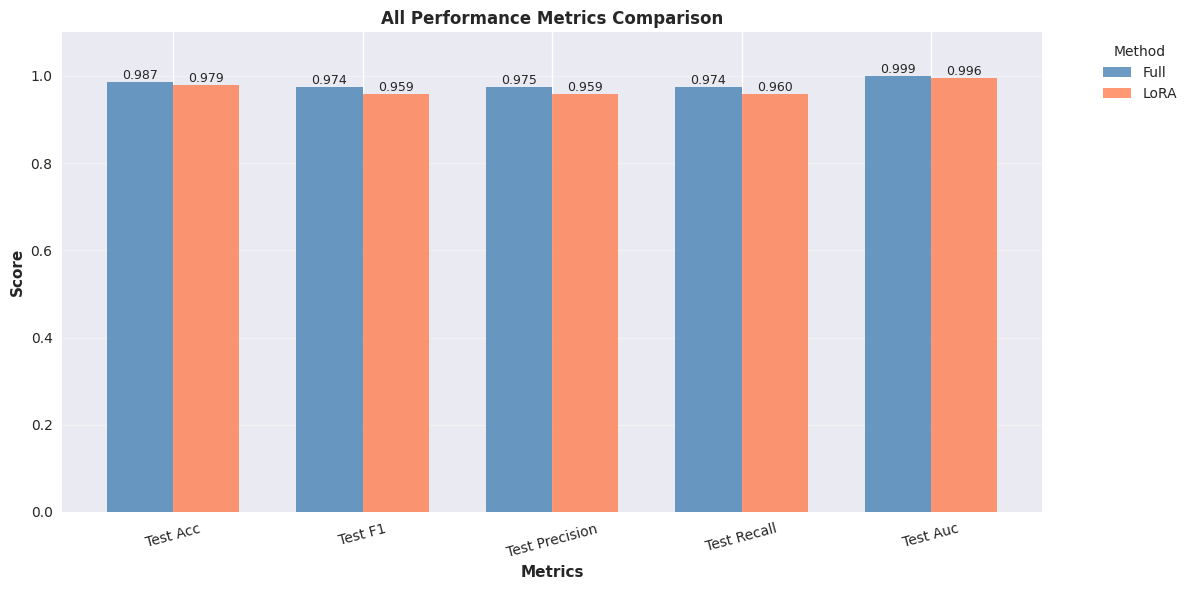

In [7]:
# All Metrics Comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics_compare = ['test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']
x = np.arange(len(metrics_compare))
width = 0.35

full_means = [full_df[m].mean() for m in metrics_compare]
lora_means = [lora_df[m].mean() for m in metrics_compare]

bars1 = ax.bar(x - width/2, full_means, width, label='Full', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, lora_means, width, label='LoRA', color='coral', alpha=0.8)

ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('All Performance Metrics Comparison', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_compare], rotation=15)
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 🧮 Statistical Tests

In [8]:
# Compute paired differences
tradeoff_results = []
for dataset in df['dataset'].unique():
    for lr in df['lr'].unique():
        full_row = df[(df['dataset']==dataset) & (df['lr']==lr) & (df['use_lora']==False)]
        lora_row = df[(df['dataset']==dataset) & (df['lr']==lr) & (df['use_lora']==True)]
        
        if len(full_row) > 0 and len(lora_row) > 0:
            # Compute overall score as average of key metrics
            full_metrics = ['test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']
            lora_metrics = ['test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']
            full_overall = full_row[full_metrics].iloc[0].mean()
            lora_overall = lora_row[lora_metrics].iloc[0].mean()
            
            tradeoff_results.append({
                'full_overall': full_overall,
                'lora_overall': lora_overall,
                'full_time': full_row.iloc[0]['avg_time_per_epoch'],
                'lora_time': lora_row.iloc[0]['avg_time_per_epoch']
            })

if len(tradeoff_results) > 0:
    tradeoff_df = pd.DataFrame(tradeoff_results)
    
    t_stat_overall, p_overall = stats.ttest_rel(tradeoff_df['lora_overall'], tradeoff_df['full_overall'])
    t_stat_time, p_time = stats.ttest_rel(tradeoff_df['lora_time'], tradeoff_df['full_time'])
    
    print("Paired t-test (LoRA vs Full):")
    print(f"{'Metric':<15} {'t-stat':<10} {'p-value':<10} {'Significance'}")
    print("-" * 50)
    print(f"{'Overall Score':<15} {t_stat_overall:<10.3f} {p_overall:<10.4f} {'*' if p_overall < 0.05 else '(ns)'}")
    print(f"{'Time':<15} {t_stat_time:<10.3f} {p_time:<10.4f} {'*' if p_time < 0.05 else '(ns)'}")

Paired t-test (LoRA vs Full):
Metric          t-stat     p-value    Significance
--------------------------------------------------
Overall Score   -1.579     0.1531     (ns)
Time            -7.450     0.0001     *


## ⚙️ Best configs for Full and LoRA

In [9]:
# Compute overall score for each experiment
df['overall_score'] = df[['test_acc', 'test_f1', 'test_precision', 'test_recall', 'test_auc']].mean(axis=1)

# Group by config and compute average overall score per config
config_cols_full = ['lr']
config_cols_lora = ['lr', 'lora_r', 'lora_alpha']

# For Full
full_configs = df[df['use_lora'] == False].groupby(config_cols_full)['overall_score'].mean().reset_index()
best_full_config = full_configs.loc[full_configs['overall_score'].idxmax()]

# For LoRA
lora_configs = df[df['use_lora'] == True].groupby(config_cols_lora)['overall_score'].mean().reset_index()
best_lora_config = lora_configs.loc[lora_configs['overall_score'].idxmax()]

# Print organized results
print("\n" + "="*80)
print("Best Configurations Based on Average Overall Score")
print("="*80)

print("\nBest Full Fine-tuning Config:")
print(f"  LR: {best_full_config['lr']}")
print(f"  Average Overall Score: {best_full_config['overall_score']:.4f}")

print("\nBest LoRA Config:")
print(f"  LR: {best_lora_config['lr']}")
print(f"  LoRA R: {best_lora_config['lora_r']}")
print(f"  LoRA Alpha: {best_lora_config['lora_alpha']}")
print(f"  Average Overall Score: {best_lora_config['overall_score']:.4f}")

print("\nAll Unique Full Configs (sorted by avg overall score):")
full_configs_sorted = full_configs.sort_values('overall_score', ascending=False)
for _, row in full_configs_sorted.iterrows():
    print(f"  LR: {row['lr']} | Avg Score: {row['overall_score']:.4f}")

print("\nAll Unique LoRA Configs (sorted by avg overall score):")
lora_configs_sorted = lora_configs.sort_values('overall_score', ascending=False)
for _, row in lora_configs_sorted.iterrows():
    print(f"  LR: {row['lr']} | R: {row['lora_r']} | Alpha: {row['lora_alpha']} | Avg Score: {row['overall_score']:.4f}")

# Print commands to run the best configs for each dataset
datasets = df['dataset'].unique()
model = "apple/mobilevit-small"
epochs = 10
batch_size = 32
num_processes = 2
num_workers = 4
seed = 42
optimizer = 'AdamW'

print("\n" + "="*80)
print("Commands to Run Best Configs (with plots and full output)")
print("="*80)

for dataset in datasets:
    data_dir = f"Data/{dataset.replace('brics2025', 'brain_tumor').replace('chest_xray', 'chest-xray').replace('lung_cancer', 'lung-cancer')}"  # Adjust based on Experiments.py
    
    # Full config command
    full_cmd = [
        "accelerate", "launch",
        f"--num_processes={num_processes}",
        "Train.py",
        "--data_dir", data_dir,
        "--model_name_or_path", model,
        f"--batch_size={batch_size}",
        f"--epochs={epochs}",
        f"--lr={best_full_config['lr']}",
        f"--optimizer={optimizer}",
        f"--num_workers={num_workers}",
        f"--seed={seed}",
        "--weight_decay=0.01",
    ]
    
    # LoRA config command
    lora_cmd = [
        "accelerate", "launch",
        f"--num_processes={num_processes}",
        "Train.py",
        "--data_dir", data_dir,
        "--model_name_or_path", model,
        f"--batch_size={batch_size}",
        f"--epochs={epochs}",
        f"--lr={best_lora_config['lr']}",
        f"--optimizer={optimizer}",
        f"--num_workers={num_workers}",
        f"--seed={seed}",
        "--use_lora",
        f"--lora_r={int(best_lora_config['lora_r'])}",
        f"--lora_alpha={int(best_lora_config['lora_alpha'])}",
        "--lora_dropout=0.1",
        "--weight_decay=0.01",
    ]
    
    print(f"\nDataset: {dataset}")
    print(f"  Full Command: {' '.join(full_cmd)}")
    print(f"  LoRA Command: {' '.join(lora_cmd)}")

print("="*80)


Best Configurations Based on Average Overall Score

Best Full Fine-tuning Config:
  LR: 0.0005
  Average Overall Score: 0.9885

Best LoRA Config:
  LR: 0.0005
  LoRA R: 4.0
  LoRA Alpha: 32.0
  Average Overall Score: 0.9789

All Unique Full Configs (sorted by avg overall score):
  LR: 0.0005 | Avg Score: 0.9885
  LR: 0.0001 | Avg Score: 0.9845
  LR: 0.001 | Avg Score: 0.9720

All Unique LoRA Configs (sorted by avg overall score):
  LR: 0.0005 | R: 4.0 | Alpha: 32.0 | Avg Score: 0.9789
  LR: 0.001 | R: 4.0 | Alpha: 32.0 | Avg Score: 0.9778
  LR: 0.0001 | R: 4.0 | Alpha: 32.0 | Avg Score: 0.9550

Commands to Run Best Configs (with plots and full output)

Dataset: brics2025
  Full Command: accelerate launch --num_processes=2 Train.py --data_dir Data/brain_tumor --model_name_or_path apple/mobilevit-small --batch_size=32 --epochs=10 --lr=0.0005 --optimizer=AdamW --num_workers=4 --seed=42 --weight_decay=0.01
  LoRA Command: accelerate launch --num_processes=2 Train.py --data_dir Data/brain_

## 🚀 Push to the Hub

**🧠 Brain Tumor (LoRA):**

```bash
python Push_to_hub.py \
  --output_dir outputs/[brain-tumor-output-dir] \
  --hub_model_id "<username>/mobilevit-small-lora-brain-tumor"
```

---

**🫁 Chest X-Ray (LoRA):**

```bash
python Push_to_hub.py \
  --output_dir outputs/[chest-xray-output-dir] \
  --hub_model_id "<username>/mobilevit-small-lora-chest-xray"
```

---

**🫀 Lung Cancer (LoRA):**

```bash
python Push_to_hub.py \
  --output_dir outputs/[lung-cancer-output-dir] \
  --hub_model_id "<username>/mobilevit-small-lora-lung-cancer"
```